In [1]:
import os
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pip install flask-ngrok

In [4]:
!pip install pytorch-forecasting

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 181.9/181.9 kB 17.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 811.0/811.0 kB 48.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 926.4/926.4 kB 57.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 19.1 MB/s eta 0:00:00


In [5]:
%load_ext tensorboard

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import torch
from pytorch_forecasting import TimeSeriesDataSet, TemporalFusionTransformer
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import RMSE
from pytorch_lightning import Trainer
import pytorch_lightning as pl
from torch.optim import Adam
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor
from pytorch_lightning.callbacks import ModelCheckpoint  # ModelCheckpoint 임포트
from pytorch_lightning.callbacks.early_stopping import EarlyStopping  # EarlyStopping 콜백도 임포트

In [7]:
# Google Drive에서 데이터 로드
train_data_path = "/content/drive/MyDrive/종설프1_5팀/전처리.ipynb/train_data.csv"
test_data_path = "/content/drive/MyDrive/종설프1_5팀/전처리.ipynb/test_data.csv"

# 데이터 로드
df_train = pd.read_csv(train_data_path)
df_test = pd.read_csv(test_data_path)

# 스케일링
scaler = MinMaxScaler()
df_train['feed_pressure'] = scaler.fit_transform(df_train[['feed_pressure']])
df_test['feed_pressure'] = scaler.transform(df_test[['feed_pressure']])

# 시간 인덱스 추가
df_train['time_idx'] = range(len(df_train))
df_test['time_idx'] = range(len(df_train), len(df_train) + len(df_test))

# 학습 및 테스트 데이터 병합
df_total = pd.concat([df_train, df_test], ignore_index=True)

In [8]:
# 테스트 데이터 길이 출력
test_data_length = len(df_train) + len(df_test)
print(f"Test data length: {test_data_length}")


Test data length: 11158


### 데이터 준비 및 설정
우선 max_encoder_length와 max_prediction_length를 설정하여 데이터의 인코더 및 예측 길이를 정의합니다.

In [9]:
# max_encoder_length와 max_prediction_length 설정
max_encoder_length = 500  #12시간
max_prediction_length = 1  #2시간

print(f"Max encoder length: {max_encoder_length} entries")
print(f"Max prediction length: {max_prediction_length} entries")

# 그룹 ID 설정
df_total["group"] = "series"  # 단일 시계열일 경우 고유 그룹 지정

Max encoder length: 500 entries
Max prediction length: 1 entries


### TimeSeriesDataSet 생성
TimeSeriesDataSet을 사용해 데이터를 생성합니다. 여기에는 타겟, 그룹화 방식, 그리고 변동하는 시계열 컬럼을 정의합니다.


In [10]:
training = TimeSeriesDataSet(
    df_total[lambda x: x.time_idx < len(df_train)],  # 학습 데이터만 사용
    time_idx="time_idx",
    target="feed_pressure",  # 타겟 변수
    group_ids=["group"],  # 그룹화
    max_encoder_length=max_encoder_length,
    max_prediction_length=max_prediction_length,
    static_categoricals=[],
    time_varying_known_reals=["time_idx"],  # 시간 관련 변수
    time_varying_unknown_reals=["feed_pressure"],  # 예측 대상 변수
    target_normalizer=GroupNormalizer(transformation="relu")  # 정규화
)

### DataLoader 생성
DataLoader를 생성하여 모델이 데이터를 학습할 수 있도록 준비합니다.

In [11]:
# 데이터 로더 재생성
train_dataloader = training.to_dataloader(train=True, batch_size=32, num_workers=0)
val_dataloader = training.to_dataloader(train=False, batch_size=32, num_workers=0)

### Temporal Fusion Transformer 모델 생성
Temporal Fusion Transformer 모델을 생성하여 데이터셋을 학습할 준비를 합니다.

In [12]:
from torchmetrics import MeanAbsoluteError

# Define the loss function
loss = MeanAbsoluteError()

# Temporal Fusion Transformer 모델 생성
tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=0.001,  # 학습률
    hidden_size=16,  # 모델의 잠재 표현 크기
    attention_head_size=1,  # 어텐션 헤드 개수 (패턴 포착)
    dropout=0.1,  # 과적합 방지
    hidden_continuous_size=16,  # 연속형 변수의 임베딩 크기
    loss=loss,  # 손실 함수 (loss 변수 사용)
    log_interval=10,  # 학습 로그 출력 빈도
    reduce_on_plateau_patience=3,  # 손실이 개선되지 않을 시 학습률 줄이는 시점
    optimizer="adam"
)

/usr/local/lib/python3.10/dist-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.


### LightningModule 정의 및 Trainer 설정
PyTorch Lightning을 이용하여 모델 학습을 보다 쉽게 관리할 수 있도록 합니다.


In [13]:
class TFTWrapper(pl.LightningModule):
    def __init__(self, tft_model):
        super().__init__()
        self.tft_model = tft_model
        self.train()  # 명시적으로 학습 모드로 설정

    def forward(self, x):
        # 모든 입력 데이터를 모델의 디바이스로 이동
        x = {key: value.to(self.device) if isinstance(value, torch.Tensor) else value for key, value in x.items()}
        return self.tft_model(x)

    def training_step(self, batch, batch_idx):
        # 모든 데이터를 모델의 디바이스로 이동
        self.train()  # 학습 스텝에서 다시 학습 모드로 전환
        x, y = batch
        x = {key: value.to(self.device) if isinstance(value, torch.Tensor) else value for key, value in x.items()}

        # y가 튜플인 경우, 첫 번째 요소만 가져오기
        if isinstance(y, tuple):
            y = y[0]
        y = y.to(self.device)

        y_hat = self(x)["prediction"]
        loss = self.tft_model.loss(y_hat, y)
        self.log("train_loss", loss, prog_bar=True, logger=True)
        return loss

    def validation_step(self, batch, batch_idx):
        # 모든 데이터를 모델의 디바이스로 이동
        x, y = batch
        x = {key: value.to(self.device) if isinstance(value, torch.Tensor) else value for key, value in x.items()}

        # y가 튜플인 경우, 첫 번째 요소만 가져오기
        if isinstance(y, tuple):
            y = y[0]
        y = y.to(self.device)

        y_hat = self(x)["prediction"]
        loss = self.tft_model.loss(y_hat, y)
        self.log("val_loss", loss, prog_bar=True, logger=True)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=0.03)
        lr_scheduler = {
            'scheduler': torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=5),
            'monitor': 'val_loss'
        }
        return [optimizer], [lr_scheduler]


## 모델 학습

In [14]:
# Google Drive가 체크폰트 저장 경로 설정
local_checkpoint_dir = "/content/checkpoints/"
drive_checkpoint_dir = "/content/drive/MyDrive/종설프1_5팀/checkpoints/"
os.makedirs(local_checkpoint_dir, exist_ok=True)
os.makedirs(drive_checkpoint_dir, exist_ok=True)

# 모델 저장
model_save_path = "/content/drive/MyDrive/종설프1_5팀/model.pth"

# 기존 체크폰트 파일 삭제 함수
def delete_existing_checkpoints(checkpoint_dir):
    if os.path.exists(checkpoint_dir):
        for filename in os.listdir(checkpoint_dir):
            file_path = os.path.join(checkpoint_dir, filename)
            try:
                if os.path.isfile(file_path):
                    os.remove(file_path)
                    print(f"Deleted checkpoint file: {file_path}")
            except Exception as e:
                print(f"Failed to delete {file_path}: {e}")


# 가장 최근 체크포인트 찾기
def get_latest_checkpoint(checkpoint_dir):
    if os.path.exists(checkpoint_dir):
        checkpoints = [os.path.join(checkpoint_dir, f) for f in os.listdir(checkpoint_dir) if f.endswith(".ckpt")]
        if checkpoints:
            return max(checkpoints, key=os.path.getctime)  # 가장 최근 파일 반환
    return None

In [15]:
# TFT 모델을 TFTWrapper로 감싸기
tft.to('cuda')
wrapped_tft = TFTWrapper(tft).to('cuda')

# Early Stopping Callback 추가
early_stop_callback = EarlyStopping(
    monitor="val_loss",
    min_delta=1e-4,
    patience=10,
    verbose=True,
    mode="min"
)

# 모델 저장 경로
checkpoint_callback = ModelCheckpoint(
    dirpath=local_checkpoint_dir,
    filename="tft-{epoch:02d}-{val_loss:.2f}",
    monitor="val_loss",
    mode="min",
    save_top_k=1,
    save_last=True
)

# 학습 실행 시 체크포인트 콜백 포함
trainer = Trainer(
    max_epochs=30,
    accelerator="gpu",
    devices=1,
    gradient_clip_val=0.3,
    precision=32,
    callbacks=[early_stop_callback, checkpoint_callback],  # 콜백 추가
)


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


<span style="color:red;">주의: 체크포인트 삭제!</span>

In [16]:
# 기존 체크포인트에서 로드 여부 확인 및 학습 실행
delete_checkpoints = input("기존 체크포인트 파일을 삭제하시겠습니까? (y/n): ").lower()

if delete_checkpoints == 'y':
    print("기존 체크포인트 파일을 삭제합니다.")
    delete_existing_checkpoints(local_checkpoint_dir)
    delete_existing_checkpoints(drive_checkpoint_dir)

    # 새 학습 시작
    trainer.fit(
        model=wrapped_tft,
        train_dataloaders=train_dataloader,
        val_dataloaders=val_dataloader
    )

else:
    print("기존 체크포인트를 유지합니다.")
    latest_checkpoint = get_latest_checkpoint(local_checkpoint_dir)

    if latest_checkpoint:
        print(f"기존 체크포인트에서 로드합니다: {latest_checkpoint}")

        # 체크포인트에서 모델 로드
        loaded_tft = TemporalFusionTransformer.load_from_checkpoint(latest_checkpoint)

        # TFTWrapper로 래핑
        wrapped_tft = TFTWrapper(tft_model=loaded_tft).to(device)

        # 기존 체크포인트에서 로드한 모델로 학습 재개
        trainer.fit(
            model=wrapped_tft,
            train_dataloaders=train_dataloader,
            val_dataloaders=val_dataloader
        )

    else:
        print("체크포인트가 없습니다. 새로 학습을 시작합니다.")

        # 새 학습 시작
        trainer.fit(
            model=wrapped_tft,
            train_dataloaders=train_dataloader,
            val_dataloaders=val_dataloader
        )


기존 체크포인트 파일을 삭제하시겠습니까? (y/n): n
기존 체크포인트를 유지합니다.
체크포인트가 없습니다. 새로 학습을 시작합니다.


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type                      | Params | Mode 
----------------------------------------------------------------
0 | tft_model | TemporalFusionTransformer | 17.7 K | train
----------------------------------------------------------------
17.7 K    Trainable params
0         Non-trainable params
17.7 K    Total params
0.071     Total estimated model params size (MB)
160       Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/data.py:78: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 32. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/data.py:78: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 10. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved. New best score: 0.042


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.013 >= min_delta = 0.0001. New best score: 0.030


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.003 >= min_delta = 0.0001. New best score: 0.027


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.004 >= min_delta = 0.0001. New best score: 0.023


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.001 >= min_delta = 0.0001. New best score: 0.022


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.001 >= min_delta = 0.0001. New best score: 0.021
INFO:pytorch_lightning.utilities.rank_zero:
Detected KeyboardInterrupt, attempting graceful shutdown ...


NameError: name 'exit' is not defined

In [17]:
# 학습 종료 후 가장 좋은 체크포인트 경로 출력
print(f"Best checkpoint saved at: {checkpoint_callback.best_model_path}")

Best checkpoint saved at: /content/checkpoints/tft-epoch=11-val_loss=0.02.ckpt


## 서버구축

In [18]:
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip ngrok-stable-linux-amd64.zip


--2024-12-01 12:43:05--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 99.83.220.108, 35.71.179.82, 13.248.244.96, ...
Connecting to bin.equinox.io (bin.equinox.io)|99.83.220.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13921656 (13M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip’

ngrok-stable-linux- 100%[===================>]  13.28M  7.24MB/s    in 1.8s    

2024-12-01 12:43:08 (7.24 MB/s) - ‘ngrok-stable-linux-amd64.zip’ saved [13921656/13921656]

Archive:  ngrok-stable-linux-amd64.zip
  inflating: ngrok                   


In [19]:
!./ngrok authtoken cr_2pQNo2X1zqJCJbgu2vzvGoq8ubY

Authtoken saved to configuration file: /root/.ngrok2/ngrok.yml


In [20]:
import torch
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score
from scipy.stats import pearsonr
import matplotlib.pyplot as plt

## 모델 다시 로드

In [23]:
print(df_test.info())
print(df_test.head())
print(df_test.tail())

print("Is time index continuous?", pd.Series(df_test["time_idx"]).is_monotonic_increasing)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2232 entries, 0 to 2231
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   time           2232 non-null   object 
 1   feed_pressure  2232 non-null   float64
 2   time_idx       2232 non-null   int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 52.4+ KB
None
                  time  feed_pressure  time_idx
0  2024 10 13 21:33:04       0.733794      8926
1  2024 10 13 21:34:04       0.629800      8927
2  2024 10 13 21:35:04       0.533026      8928
3  2024 10 13 21:36:04       0.445622      8929
4  2024 10 13 21:37:04       0.500922      8930
                     time  feed_pressure  time_idx
2227  2024 10 15 10:40:31       0.629032     11153
2228  2024 10 15 10:41:31       0.550384     11154
2229  2024 10 15 10:42:31       0.607834     11155
2230  2024 10 15 10:43:31       0.647158     11156
2231  2024 10 15 10:44:31       0.685407     11157
Is time inde

In [24]:
# Train/Test 데이터에 'group' 열 추가
df_train["group"] = "series"
df_test["group"] = "series"

# Train/Test 데이터 병합
df_total = pd.concat([df_train, df_test], ignore_index=True)

# 데이터 병합 후 확인
print(f"Dataset length after merge: {len(df_total)}")
print(df_total.head())
print(df_total.tail())

# max_encoder_length와 max_prediction_length 설정
max_encoder_length = 30  # 최대 인코더 길이
max_prediction_length = 1  # 최대 예측 길이

# 데이터셋 구성
try:
    training = TimeSeriesDataSet(
        df_total[lambda x: x.time_idx < len(df_train)],  # 학습 데이터만 사용
        time_idx="time_idx",
        target="feed_pressure",
        group_ids=["group"],  # 그룹 설정
        max_encoder_length=max_encoder_length,
        max_prediction_length=max_prediction_length,
        static_categoricals=[],
        time_varying_known_reals=["time_idx"],
        time_varying_unknown_reals=["feed_pressure"],
        target_normalizer=GroupNormalizer(transformation="relu")
    )
    print(f"Training dataset successfully created with {len(training)} samples.")
except AssertionError as e:
    print("AssertionError during dataset creation:", e)


Dataset length after merge: 11158
                  time  feed_pressure  time_idx   group
0  2024 10 07 16:42:21       0.081106         0  series
1  2024 10 07 16:43:21       0.113825         1  series
2  2024 10 07 16:44:21       0.145315         2  series
3  2024 10 07 16:45:21       0.175883         3  series
4  2024 10 07 16:46:21       0.212135         4  series
                      time  feed_pressure  time_idx   group
11153  2024 10 15 10:40:31       0.629032     11153  series
11154  2024 10 15 10:41:31       0.550384     11154  series
11155  2024 10 15 10:42:31       0.607834     11155  series
11156  2024 10 15 10:43:31       0.647158     11156  series
11157  2024 10 15 10:44:31       0.685407     11157  series
Training dataset successfully created with 8896 samples.


In [25]:
# Train/Test 데이터 병합
df_total = pd.concat([df_train, df_test], ignore_index=True)

# 데이터 병합 후 확인
print(f"Dataset length after merge: {len(df_total)}")
print(df_total.head())
print(df_total.tail())

# 데이터 길이에 따른 설정값 조정
max_encoder_length = min(len(df_train), 30)  # 데이터 길이에 맞게 조정
max_prediction_length = 1  # 예측 길이는 그대로 유지

print(f"Adjusted max_encoder_length: {max_encoder_length}")
print(f"Adjusted max_prediction_length: {max_prediction_length}")

# 데이터셋 구성
try:
    training = TimeSeriesDataSet(
        df_total[lambda x: x.time_idx < len(df_train)],  # 학습 데이터만 사용
        time_idx="time_idx",
        target="feed_pressure",
        group_ids=["group"],
        max_encoder_length=max_encoder_length,
        max_prediction_length=max_prediction_length,
        static_categoricals=[],
        time_varying_known_reals=["time_idx"],
        time_varying_unknown_reals=["feed_pressure"],
        target_normalizer=GroupNormalizer(transformation="relu")
    )
    print(f"Training dataset successfully created with {len(training)} samples.")
except AssertionError as e:
    print("AssertionError during dataset creation:", e)


Dataset length after merge: 11158
                  time  feed_pressure  time_idx   group
0  2024 10 07 16:42:21       0.081106         0  series
1  2024 10 07 16:43:21       0.113825         1  series
2  2024 10 07 16:44:21       0.145315         2  series
3  2024 10 07 16:45:21       0.175883         3  series
4  2024 10 07 16:46:21       0.212135         4  series
                      time  feed_pressure  time_idx   group
11153  2024 10 15 10:40:31       0.629032     11153  series
11154  2024 10 15 10:41:31       0.550384     11154  series
11155  2024 10 15 10:42:31       0.607834     11155  series
11156  2024 10 15 10:43:31       0.647158     11156  series
11157  2024 10 15 10:44:31       0.685407     11157  series
Adjusted max_encoder_length: 30
Adjusted max_prediction_length: 1
Training dataset successfully created with 8896 samples.


In [26]:
# 누락된 group 값을 채움
df_total['group'] = df_total['group'].fillna("series")
print("Missing group values filled.")


Missing group values filled.


## non-rolling 방식

In [28]:
def predict_with_model(model, dataset):
    # 모델의 디바이스 확인 및 설정
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)  # 모델을 GPU로 이동
    print(f"Model is on device: {device}")

    dataloader = dataset.to_dataloader(train=False, batch_size=1, num_workers=0)
    predictions = []

    for batch in dataloader:
        x, _ = batch
        # 배치 데이터를 모델 디바이스로 강제 이동
        x = {key: value.to(device) if isinstance(value, torch.Tensor) else value for key, value in x.items()}

        # 디버깅: 각 텐서의 디바이스 확인
        for key, value in x.items():
            if isinstance(value, torch.Tensor):
                print(f"Key: {key}, Device: {value.device}")

        with torch.no_grad():
            pred = model(x)["prediction"].cpu().numpy()  # 예측 결과를 CPU로 이동 후 NumPy 변환
        predictions.append(pred)

    return np.concatenate(predictions)




# 테스트 데이터셋 생성 및 예측
test_dataset = TimeSeriesDataSet(
    df_total[lambda x: x.time_idx >= len(df_train)],  # 테스트 데이터만 사용
    time_idx="time_idx",
    target="feed_pressure",
    group_ids=["group"],
    max_encoder_length=max_encoder_length,
    max_prediction_length=max_prediction_length,
    static_categoricals=[],
    time_varying_known_reals=["time_idx"],
    time_varying_unknown_reals=["feed_pressure"],
    target_normalizer=GroupNormalizer(transformation="relu")
)

# 예측 수행
predictions = predict_with_model(wrapped_tft, test_dataset)
print("Predictions:", predictions)


스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
Key: decoder_lengths, Device: cuda:0
Key: decoder_time_idx, Device: cuda:0
Key: groups, Device: cuda:0
Key: target_scale, Device: cuda:0
Key: encoder_cat, Device: cuda:0
Key: encoder_cont, Device: cuda:0
Key: encoder_target, Device: cuda:0
Key: encoder_lengths, Device: cuda:0
Key: decoder_cat, Device: cuda:0
Key: decoder_cont, Device: cuda:0
Key: decoder_target, Device: cuda:0
Key: decoder_lengths, Device: cuda:0
Key: decoder_time_idx, Device: cuda:0
Key: groups, Device: cuda:0
Key: target_scale, Device: cuda:0
Key: encoder_cat, Device: cuda:0
Key: encoder_cont, Device: cuda:0
Key: encoder_target, Device: cuda:0
Key: encoder_lengths, Device: cuda:0
Key: decoder_cat, Device: cuda:0
Key: decoder_cont, Device: cuda:0
Key: decoder_target, Device: cuda:0
Key: decoder_lengths, Device: cuda:0
Key: decoder_time_idx, Device: cuda:0
Key: groups, Device: cuda:0
Key: target_scale, Device: cuda:0
Key: encoder_cat, Device: cuda:0
Key: encoder_cont, Device: cuda:0


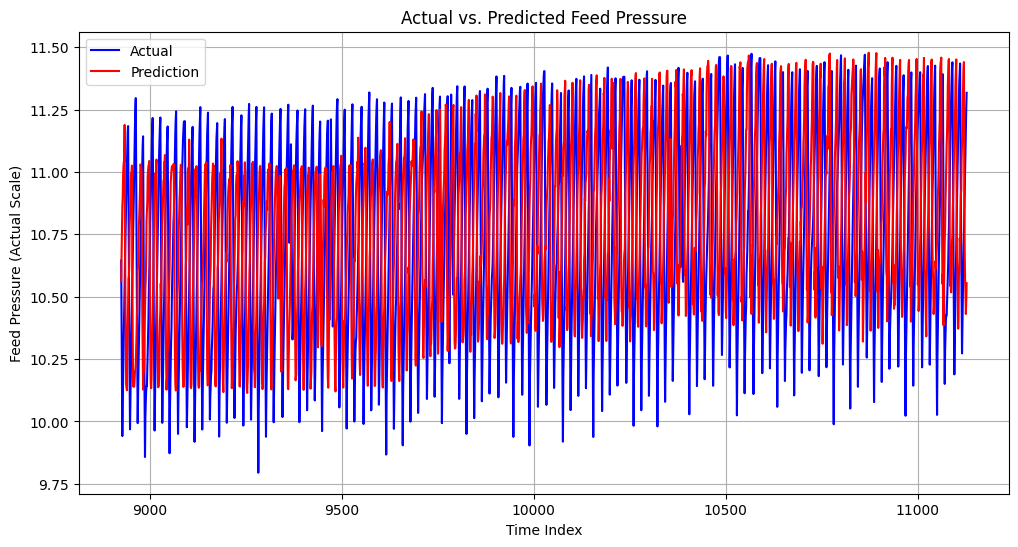

In [29]:
import numpy as np
import matplotlib.pyplot as plt

def plot_predictions(true_values, predicted_values, time_indices):
    """
    예측 값과 실제 값을 시각화합니다.

    Args:
    - true_values (array-like): 실제 값
    - predicted_values (array-like): 예측 값
    - time_indices (array-like): 시간 인덱스

    Returns:
    - None
    """
    plt.figure(figsize=(12, 6))
    plt.plot(time_indices, true_values, label="Actual", linestyle="-", color="blue")
    plt.plot(time_indices, predicted_values, label="Prediction", linestyle="-", color="red")
    plt.xlabel("Time Index")
    plt.ylabel("Feed Pressure (Actual Scale)")
    plt.title("Actual vs. Predicted Feed Pressure")
    plt.legend()
    plt.grid(True)
    plt.show()

# 예측 값 차원 맞추기
predictions = np.array(predictions).squeeze()  # (2202, 1, 1) -> (2202,)
true_values = np.array(df_test["feed_pressure"].values)  # 실제 값
time_indices = np.array(df_test["time_idx"].values)  # 시간 인덱스

# 차원 맞추기: 예측 값과 실제 값의 길이가 다를 경우 자르기
min_length = min(len(true_values), len(predictions), len(time_indices))
true_values = true_values[:min_length]
predictions = predictions[:min_length]
time_indices = time_indices[:min_length]

# 스케일링된 값을 실제 값으로 복원 (inverse transform)
true_values_actual = scaler.inverse_transform(true_values.reshape(-1, 1)).flatten()
predictions_actual = scaler.inverse_transform(predictions.reshape(-1, 1)).flatten()

# 시각화 호출
plot_predictions(true_values_actual, predictions_actual, time_indices)


## ROLLING 방식

In [43]:
def rolling_predict_with_model(model, dataset, max_encoder_length, scaler, device='cuda'):
    model = model.to(device)
    model.eval()

    predictions = []
    input_data = dataset[:max_encoder_length].copy()

    print("Initial dataset for rolling prediction:")
    print(input_data.head())

    for i in range(len(dataset) - max_encoder_length):    # 예측 범위 지정
        try:
            # TimeSeriesDataSet 생성
            rolling_dataset = TimeSeriesDataSet(
                data=input_data,
                time_idx="time_idx",
                target="feed_pressure",
                group_ids=["group"],
                max_encoder_length=max_encoder_length,
                max_prediction_length=1,
                static_categoricals=[],
                time_varying_known_reals=["time_idx"],
                time_varying_unknown_reals=["feed_pressure"],
                target_normalizer=GroupNormalizer(transformation="relu"),
                min_encoder_length=1,
                allow_missing_timesteps=True,
            )

            rolling_dataloader = rolling_dataset.to_dataloader(train=False, batch_size=1)

            # 예측 수행
            with torch.no_grad():
                input_batch = next(iter(rolling_dataloader))
                input_batch = {key: value.to(device) for key, value in input_batch[0].items()}
                prediction = model(input_batch)["prediction"].cpu().numpy().squeeze()

            predictions.append(prediction)

            # 슬라이딩 윈도우 업데이트
            new_row = dataset.iloc[max_encoder_length + i].copy()
            new_row["feed_pressure"] = float(prediction)  # ndarray를 float으로 변환
            input_data = pd.concat([input_data.iloc[1:], pd.DataFrame([new_row])], ignore_index=True)
        except Exception as e:
            print(f"Error at step {i}: {e}")
            break

    predictions = scaler.inverse_transform(np.array(predictions).reshape(-1, 1)).flatten()
    return predictions


In [44]:
# 데이터 길이에 맞게 max_encoder_length 조정
if len(df_test) < max_encoder_length + 1:
    max_encoder_length = len(df_test) - 1
    print(f"Adjusted max_encoder_length: {max_encoder_length}")


Initial dataset for rolling prediction:
                  time  feed_pressure  time_idx   group
0  2024 10 13 21:33:04       0.733794      8926  series
1  2024 10 13 21:34:04       0.629800      8927  series
2  2024 10 13 21:35:04       0.533026      8928  series
3  2024 10 13 21:36:04       0.445622      8929  series
4  2024 10 13 21:37:04       0.500922      8930  series
Length of rolling_predictions: 2202
Length of true_values: 2232


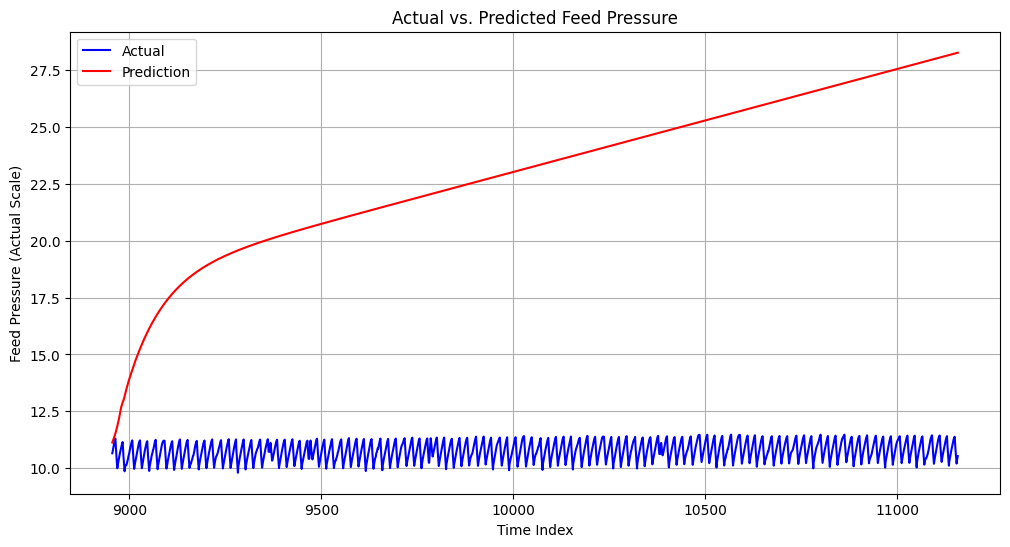

In [46]:
# Rolling Prediction 실행
rolling_predictions = rolling_predict_with_model(
    model=wrapped_tft,
    dataset=df_test,
    max_encoder_length=max_encoder_length,
    scaler=scaler,
    device='cuda',
)

# Rolling Prediction의 길이 확인
print(f"Length of rolling_predictions: {len(rolling_predictions)}")
print(f"Length of true_values: {len(df_test)}")

# rolling_predictions와 true_values 길이 맞추기
rolling_predictions = rolling_predictions[:len(df_test)]

# 결과 시각화
true_values = scaler.inverse_transform(df_test["feed_pressure"].values.reshape(-1, 1)).flatten()
time_indices = df_test["time_idx"].values

# true_values와 time_indices를 예측 가능한 범위로 슬라이싱
true_values_adjusted = true_values[max_encoder_length:]
time_indices_adjusted = time_indices[max_encoder_length:]

# 시각화
plot_predictions(true_values_adjusted, rolling_predictions, time_indices_adjusted)

